In [1]:
import os
import cv2
import pandas as pd
import numpy as np
#import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread

In [2]:
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPool2D 
from tensorflow.keras.initializers import RandomNormal

In [3]:
X_train_tmp_folder_path = r"C:\Hyundai GAN\mat_ccgan\disc_temp_mat\572"
X_train_dsp_folder_path =r"C:\Hyundai GAN\mat_ccgan\disc_disp_mat\572"
Y_train_folder_path = r"C:\Hyundai GAN\UNet\unet_images\resized\upscale\388"

In [4]:
X_train_tmp_elements = os.listdir(X_train_tmp_folder_path) 
X_train_dsp_elements = os.listdir(X_train_dsp_folder_path) 
Y_train_elements = os.listdir(Y_train_folder_path)

In [5]:
X_train = np.zeros((20,572,572,2))
Y_train = np.zeros((20,388,388,1))

In [6]:
# DEVELOPING X_train MATRIX

for index, (tmp_element, dsp_element) in enumerate(zip(X_train_tmp_elements, X_train_dsp_elements)):
    # Load images for each channel
    tmp_element_path = os.path.join(X_train_tmp_folder_path, tmp_element)
    dsp_element_path = os.path.join(X_train_dsp_folder_path, dsp_element)
    img_tmp = imread(tmp_element_path)
    img_dsp = imread(dsp_element_path)
    
    # Reshape images for each channel
    img_tmp = img_tmp.reshape((572,572, 1))
    img_dsp = img_dsp.reshape((572,572, 1))
    
    # Combine channels
    img_combined = np.concatenate((img_tmp, img_dsp), axis=2)
    
    # Assign to X_train
    X_train[index] = img_combined

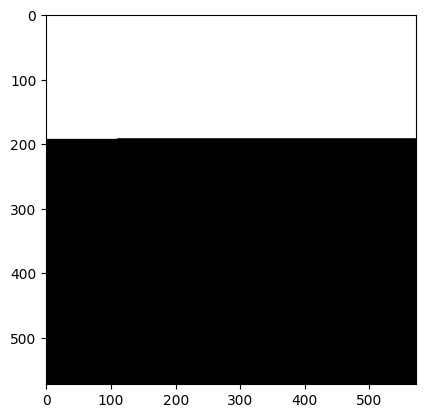

In [7]:
idx=np.random.randint(1,len(X_train))
plt.imshow(X_train[idx][:,:,1],cmap='gray')


In [8]:
# DEVELOPING Y_train MATRIX
for index,Y_train_element in enumerate(Y_train_elements):
    element_path = os.path.join(Y_train_folder_path, Y_train_element)
    img = imread(element_path)
    
    img = np.mean(img, axis=2)
    img = img/255
    img = img.reshape((388, 388, 1))
    Y_train[index] = img

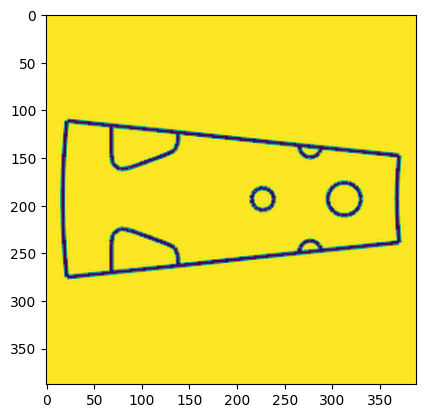

In [9]:
plt.imshow(Y_train[5])

In [10]:
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Concatenate, Cropping2D, ReLU

def crop_and_concat(up_input, down_input):

    crop_height = (down_input.shape[1] - up_input.shape[1]) // 2
    crop_width = (down_input.shape[2] - up_input.shape[2]) // 2

    cropped_down_input = Cropping2D(cropping=((crop_height, crop_height), (crop_width, crop_width)))(down_input)
    
    
    concatenated = Concatenate()([up_input, cropped_down_input])
    
    return concatenated

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.initializers import RandomNormal

init = RandomNormal(stddev=0.02, seed=42)

def unet(input_size=(572, 572, 2)):
    inputs = layers.Input(input_size)

    # Contracting path
    c1 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer=init)(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer=init)(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer=init)(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer=init)(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer=init)(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer=init)(c3)
    
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer=init)(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer=init)(c4) 
    p4 = layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = layers.Conv2D(1024, (3, 3), activation='relu', kernel_initializer=init)(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', kernel_initializer=init)(c5)

    # Expansive path
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer=init)(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer=init)(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer=init)(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer=init)(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer=init)(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer=init)(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer=init)(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer=init)(c9)

    outputs = layers.Conv2D(1, (1, 1))(c9)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Example usage
unet_model = unet(input_size=(572, 572, 2))

unet_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 572, 572, 2)]     0         
                                                                 
 conv2d (Conv2D)             (None, 570, 570, 64)      1216      
                                                                 
 conv2d_1 (Conv2D)           (None, 568, 568, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 284, 284, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 282, 282, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 280, 280, 128)     147584    
                                                             

In [12]:
optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
bce=tf.keras.losses.BinaryCrossentropy(from_logits=True)
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_dataset = train_dataset.batch(2).shuffle(10000)

def train_step(train_image,target,step):
    with tf.GradientTape() as tape:
        preds=unet_model(train_image,training=False)
        loss=bce(preds,target)
    grads=tape.gradient(loss,unet_model.trainable_variables)
    optimizer.apply_gradients(zip(grads,unet_model.trainable_variables))
    return loss

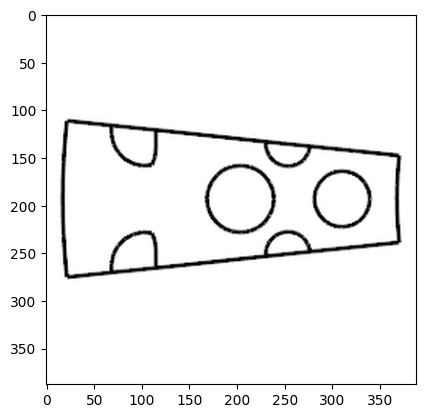

In [13]:
plt.imshow(train_dataset.as_numpy_iterator().next()[1][0][:,:,0],cmap='gray')

In [20]:
#@tf.function
def train(train_dataset,epochs):
    for epoch in range(epochs):
        for step, (x_batch, y_batch) in enumerate(train_dataset):
            
            print('.',end='')
            loss=train_step(x_batch,y_batch,step)
        print('Loss after epoch :',loss)    

In [21]:
train(train_dataset,1)

.

ResourceExhaustedError: Exception encountered when calling layer "conv2d_transpose_3" "                 f"(type Conv2DTranspose).

{{function_node __wrapped__Conv2DBackpropInput_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[128,64,2,2] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2DBackpropInput]

Call arguments received by layer "conv2d_transpose_3" "                 f"(type Conv2DTranspose):
  • inputs=tf.Tensor(shape=(2, 196, 196, 128), dtype=float32)

In [18]:
unet_model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['accuracy'])

In [19]:
unet_model.fit(X_train,Y_train,epochs = 10, batch_size=2)

Epoch 1/10


ResourceExhaustedError: Graph execution error:

Detected at node 'model/conv2d_transpose_3/conv2d_transpose' defined at (most recent call last):
    File "C:\Users\GAN Project\anaconda3\envs\tf_env\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\GAN Project\anaconda3\envs\tf_env\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\GAN Project\anaconda3\envs\tf_env\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "C:\Users\GAN Project\anaconda3\envs\tf_env\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "C:\Users\GAN Project\anaconda3\envs\tf_env\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "C:\Users\GAN Project\anaconda3\envs\tf_env\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\GAN Project\anaconda3\envs\tf_env\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\GAN Project\anaconda3\envs\tf_env\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\GAN Project\anaconda3\envs\tf_env\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\GAN Project\anaconda3\envs\tf_env\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "C:\Users\GAN Project\anaconda3\envs\tf_env\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "C:\Users\GAN Project\anaconda3\envs\tf_env\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "C:\Users\GAN Project\anaconda3\envs\tf_env\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "C:\Users\GAN Project\anaconda3\envs\tf_env\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "C:\Users\GAN Project\anaconda3\envs\tf_env\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "C:\Users\GAN Project\anaconda3\envs\tf_env\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\GAN Project\anaconda3\envs\tf_env\lib\site-packages\IPython\core\interactiveshell.py", line 3048, in run_cell
      result = self._run_cell(
    File "C:\Users\GAN Project\anaconda3\envs\tf_env\lib\site-packages\IPython\core\interactiveshell.py", line 3103, in _run_cell
      result = runner(coro)
    File "C:\Users\GAN Project\anaconda3\envs\tf_env\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\GAN Project\anaconda3\envs\tf_env\lib\site-packages\IPython\core\interactiveshell.py", line 3308, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\GAN Project\anaconda3\envs\tf_env\lib\site-packages\IPython\core\interactiveshell.py", line 3490, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\GAN Project\anaconda3\envs\tf_env\lib\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\GAN Project\AppData\Local\Temp\ipykernel_13012\1084427622.py", line 1, in <module>
      unet_model.fit(X_train,Y_train,epochs = 10, batch_size=2)
    File "C:\Users\GAN Project\anaconda3\envs\tf_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\GAN Project\anaconda3\envs\tf_env\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\GAN Project\anaconda3\envs\tf_env\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\GAN Project\anaconda3\envs\tf_env\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\GAN Project\anaconda3\envs\tf_env\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\GAN Project\anaconda3\envs\tf_env\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\GAN Project\anaconda3\envs\tf_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\GAN Project\anaconda3\envs\tf_env\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\GAN Project\anaconda3\envs\tf_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\GAN Project\anaconda3\envs\tf_env\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\GAN Project\anaconda3\envs\tf_env\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\GAN Project\anaconda3\envs\tf_env\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\GAN Project\anaconda3\envs\tf_env\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\GAN Project\anaconda3\envs\tf_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\GAN Project\anaconda3\envs\tf_env\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\GAN Project\anaconda3\envs\tf_env\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\GAN Project\anaconda3\envs\tf_env\lib\site-packages\keras\layers\convolutional\conv2d_transpose.py", line 296, in call
      outputs = backend.conv2d_transpose(
    File "C:\Users\GAN Project\anaconda3\envs\tf_env\lib\site-packages\keras\backend.py", line 6119, in conv2d_transpose
      x = tf.compat.v1.nn.conv2d_transpose(
Node: 'model/conv2d_transpose_3/conv2d_transpose'
OOM when allocating tensor with shape[128,64,2,2] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/conv2d_transpose_3/conv2d_transpose}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_6187]

1/1 [==============================] - 1s 810ms/step


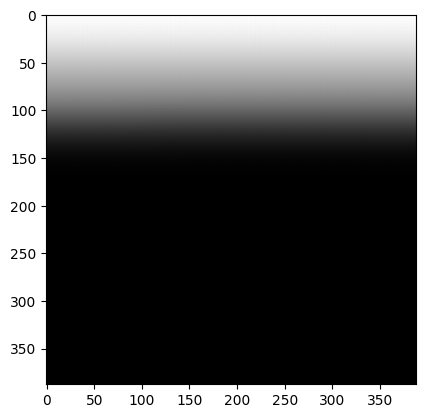

In [51]:
pred_out_com_1 = unet_model.predict(tf.expand_dims(X_train[3],axis=0))

pred_out_com_1 = pred_out_com_1.reshape((388, 388))

plt.imshow(pred_out_com_1, cmap = 'gray')

1/1 [==============================] - 1s 677ms/step


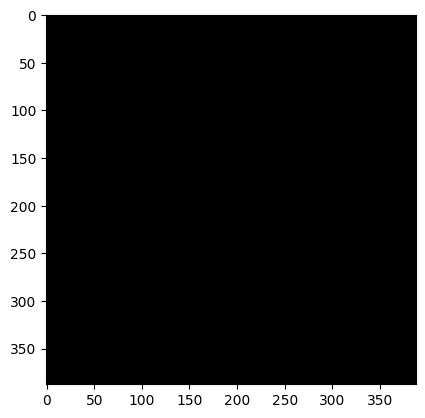

In [24]:
pred_out_com_1 = unet_model.predict(tf.expand_dims(X_train[3],axis=0))

pred_out_com_1 = pred_out_com_1.reshape((388, 388))

plt.imshow(pred_out_com_1, cmap = 'gray')

In [14]:
pred_in_com_1_tmp_path = r"C:\Hyundai GAN\mat_ccgan\disc_temp_mat\572\cc_572_temp_cv_273_in.png"
pred_in_com_1_dsp_path = r"C:\Hyundai GAN\mat_ccgan\disc_disp_mat\572\cc_572_disp_cv_273_in.png"
pred_in_com_1_tmp = imread(pred_in_com_1_tmp_path)
pred_in_com_1_dsp = imread(pred_in_com_1_dsp_path)

pred_in_com_1_tmp = pred_in_com_1_tmp.reshape((572, 572, 1))
pred_in_com_1_dsp = pred_in_com_1_dsp.reshape((572, 572, 1))

pred_in_com_1 = np.concatenate((pred_in_com_1_tmp, pred_in_com_1_dsp), axis=2)

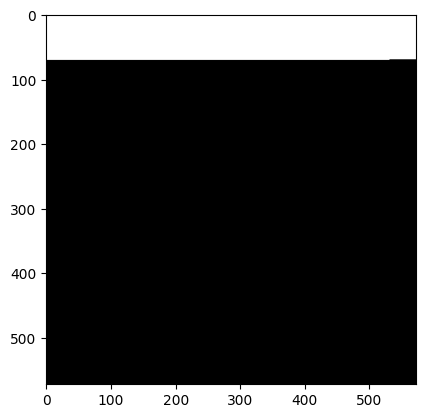

In [15]:
plt.imshow(pred_in_com_1_tmp, cmap = 'gray')

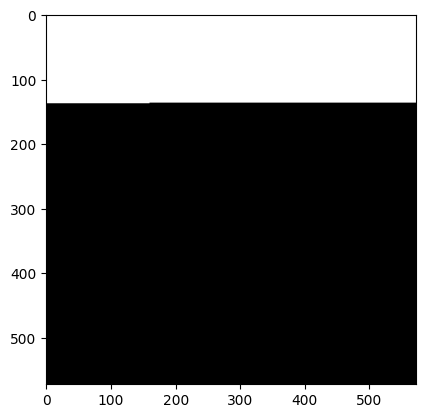

In [16]:
plt.imshow(pred_in_com_1_dsp, cmap = 'gray')

1/1 [==============================] - 1s 1s/step


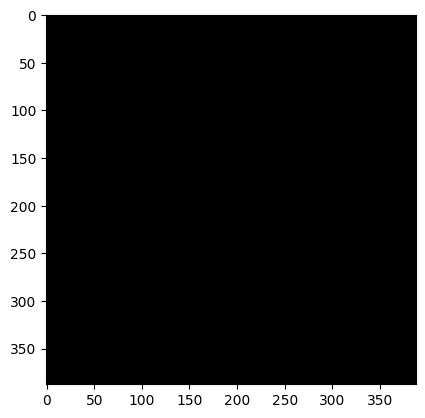

In [17]:
pred_in_com_1 = pred_in_com_1.reshape((1,572,572,2))

pred_out_com_1 = model.predict(pred_in_com_1)

pred_out_com_1 = pred_out_com_1.reshape((388, 388))

plt.imshow(pred_out_com_1, cmap = 'gray')